In [1]:
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision as tv
import torchvision.transforms as tvtf
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn as nn

In [2]:
IMAGE_FOLDER = '../datasets/mcq10k'
IMAGE_METADATA = '../datasets/mcq10k/mcq10k.csv'

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [4]:
class OMRDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)

        label = torch.from_numpy( self.img_labels.iloc[idx, 1:].to_numpy(dtype=np.float64))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
transform = tvtf.Compose([ tvtf.Resize((227, 227)), tvtf.ConvertImageDtype(torch.float64), tvtf.Normalize(0.5, 0.5), ])
trainset = OMRDataset(IMAGE_METADATA, IMAGE_FOLDER, transform=transform)

In [6]:
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 227, 227])
Labels batch shape: torch.Size([64, 4])


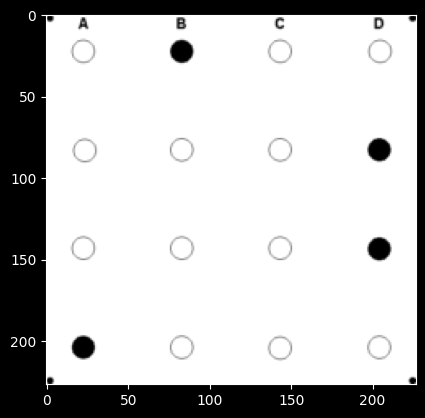

Label: tensor([2., 4., 4., 1.], dtype=torch.float64)


In [7]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels
plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label[0]}")

In [8]:
class AlexNetSingleChannel(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNetSingleChannel(num_classes=4, dropout=0.5).to(device=device)
model

AlexNetSingleChannel(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096,

In [9]:
learning_rate = 0.00001
num_epochs = 10


loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [10]:
data = next(iter(train_dataloader))
output = model(data[0].float().to(device))
loss = loss_fn(output, data[1].to(device))
loss

tensor(0.7167, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [11]:
total_step = len(train_dataloader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.float().to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss))


Epoch [1/10], Step [157/157], Loss: 0.6951
Epoch [2/10], Step [157/157], Loss: 0.6766
Epoch [3/10], Step [157/157], Loss: 0.6475
Epoch [4/10], Step [157/157], Loss: 0.6287
Epoch [5/10], Step [157/157], Loss: 0.6157
Epoch [6/10], Step [157/157], Loss: 0.5927
Epoch [7/10], Step [157/157], Loss: 0.5601
Epoch [8/10], Step [157/157], Loss: 0.5335
Epoch [9/10], Step [157/157], Loss: 0.5043
Epoch [10/10], Step [157/157], Loss: 0.4863


tensor([0., 4., 4., 2.], dtype=torch.float64)


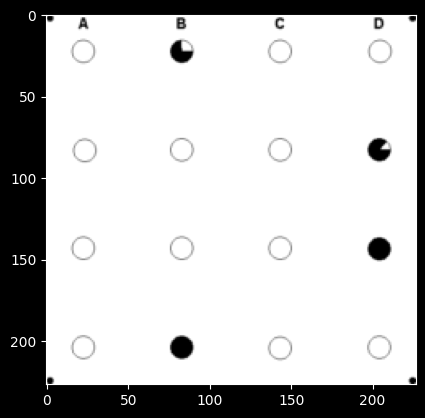

tensor([[0.1100, 0.1084, 0.1074, 0.1088],
        [0.1068, 0.0999, 0.1064, 0.1112],
        [0.1059, 0.1011, 0.1113, 0.1133],
        [0.0954, 0.1003, 0.1035, 0.1139],
        [0.1134, 0.1029, 0.1034, 0.1151],
        [0.1012, 0.0978, 0.1086, 0.1045],
        [0.1062, 0.1071, 0.1119, 0.1096],
        [0.1060, 0.1046, 0.1078, 0.1155],
        [0.0986, 0.1017, 0.1021, 0.1074],
        [0.0989, 0.0997, 0.1032, 0.1178],
        [0.1070, 0.1070, 0.1100, 0.1051],
        [0.1083, 0.1143, 0.1070, 0.1053],
        [0.1069, 0.1078, 0.1145, 0.1040],
        [0.0992, 0.1076, 0.1067, 0.1088],
        [0.1067, 0.1052, 0.1140, 0.1040],
        [0.1122, 0.1018, 0.1090, 0.1159],
        [0.1051, 0.1062, 0.1052, 0.1082],
        [0.1036, 0.0986, 0.1125, 0.1111],
        [0.1169, 0.1034, 0.1075, 0.1062],
        [0.1143, 0.1045, 0.1072, 0.1082],
        [0.1024, 0.1072, 0.1124, 0.1016],
        [0.1102, 0.1022, 0.1077, 0.1113],
        [0.1122, 0.1112, 0.1138, 0.1098],
        [0.1143, 0.1025, 0.1090, 0

C:\Users\ragas\AppData\Local\Temp\ipykernel_10544\2401984502.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = nn.functional.softmax(outputs)


RuntimeError: The size of tensor a (64) must match the size of tensor b (4) at non-singleton dimension 1

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        img = images[0].squeeze()
        print(labels[0])

        images = images.float().to(device)
        labels = labels.to(device)


        plt.imshow(img, cmap="gray")
        plt.show()

        outputs = model(images)
        print(outputs)
        outputs = nn.functional.softmax(outputs)

        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))
